# Algorithm for leaf growth

In [1]:
import math
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from sympy import *
from scipy.optimize import brentq
from scipy.interpolate import CubicSpline, splev, splrep

from openalea.archicrop.stics_io import read_sti_file
from openalea.archicrop.cereal_axis import bell_shaped_dist, geometric_dist, collar_heights_kaitaniemi
from openalea.archicrop.cereal_leaf import sr_dornbush
from openalea.archicrop.growth import demand_dist, equal_dist

from ipywidgets import interact, interactive, IntSlider, FloatSlider, fixed, Play, HBox, VBox, jslink

Import test STICS data

In [2]:
# Data points
stics_output_file = 'mod_s02NT18SorgV2D1.sti'
stics_output_file = 'mod_swheat.sti'
# density = 10
# inter_row = 0.4
stics_output_data, density = read_sti_file(stics_output_file)
time = [value["Thermal time"] for value in stics_output_data.values()]
LA_stics = [value["Plant leaf area"] for value in stics_output_data.values()]
height_stics = [value["Plant height"] for value in stics_output_data.values()]
par_stics = [value["Absorbed PAR"] for value in stics_output_data.values()]
height_potential_plant = max(height_stics)

In [3]:
# Create the cubic spline interpolator
# cs = CubicSpline(time, LA_stics)

In [4]:
# # Compute the first derivative
# cs_derivative = cs.derivative()

# # Evaluate the derivative at specific points
# x_dense = np.arange(min(time), max(time), 1)  # Fine grid for plotting
# y_dense = cs(x_dense)                       # Interpolated values
# dy_dense = cs_derivative(x_dense)           # Derivative values

## $H_0$: Linear leaf area growth

Inputs:
- number of phytomers $N_{phy}$
- development parameters: phyllochron $\phi$, ligulochron $lig$
- leaf area distribution in plant: $leaf\_area = f(rank, params)$ with $params = (r_{max}, skew)$
- maximal plant leaf area $S_{max}$

Steps:
- Define number of phytomers

In [5]:
nb_phy = 10

- Define leaf development from appearance to ligulation 

In [6]:
def dev(phyllochron, ligulochron, nb_phy):

    for i in range(1,nb_phy+1):
        start = (i-1) * phyllochron
        end = start + ligulochron
        plt.plot(np.linspace(start, end, 2), [i,i], color="g")
    
    # plt.fill_between([end/2.1,end/2.1+25], 0, nb_phy, color="grey", alpha=0.4)
    plt.xlabel("Thermal time (°C.d)")
    plt.ylabel("Phytomer rank")
    plt.xlim(0,end)
    plt.show()

interact(dev, phyllochron=IntSlider(min=30,max=60,step=5,value=45), ligulochron=IntSlider(min=50,max=100,step=5,value=80), nb_phy=fixed(nb_phy))

interactive(children=(IntSlider(value=45, description='phyllochron', max=60, min=30, step=5), IntSlider(value=…

<function __main__.dev(phyllochron, ligulochron, nb_phy)>

- Define allometric law for relative leaf area as a function of phytomer rank

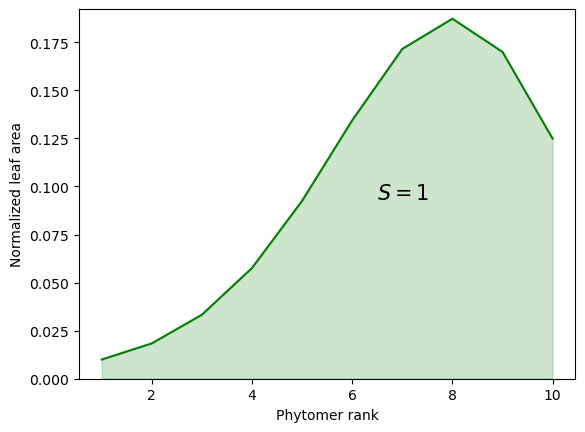

In [7]:
rmax = 0.8
skew = 0.01
Smax = 1

leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

plt.plot(range(1,len(leaf_areas)+1), leaf_areas, color="g")
plt.fill_between(range(1,len(leaf_areas)+1), [0]*len(leaf_areas), leaf_areas, color="g", alpha=0.2)
plt.ylim(0,max(leaf_areas)+0.005)
plt.xlabel("Phytomer rank")
plt.ylabel("Normalized leaf area")
plt.text(rmax*nb_phy-1.5, max(leaf_areas)/2, '$S = 1$', fontsize = 15)
plt.show()

- Scale the leaf areas according to the given maximal plant leaf area $S_{max}$

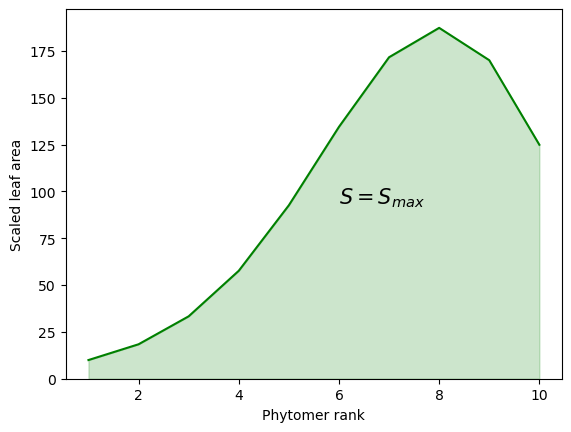

In [8]:
Smax = 1000
scaled_leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

plt.plot(range(1,len(scaled_leaf_areas)+1), scaled_leaf_areas, color="g")
plt.fill_between(range(1,len(scaled_leaf_areas)+1), [0]*len(scaled_leaf_areas), scaled_leaf_areas, color="g", alpha=0.2)
plt.ylim(0,max(scaled_leaf_areas)+10)
plt.xlabel("Phytomer rank")
plt.ylabel("Scaled leaf area")
plt.text(rmax*nb_phy-2, max(scaled_leaf_areas)/2, '$S = S_{max}$', fontsize = 15)
plt.show()

- At each time step, knowing H0, add the leaf area increment of each growing organ to the sum of appeared leaf area. 

In [9]:
def linear_leaf_growth(phyllochron, ligulochron, nb_phy):

    fig, ax1 = plt.subplots()

    starts = []
    ends = []

    for i in range(nb_phy):
        start = i * phyllochron
        end = start + ligulochron
        
        starts.append(start)
        ends.append(end)
        ax1.plot(np.linspace(start, end, 2), [0,scaled_leaf_areas[i]], color="g")
        ax1.text(end-4, scaled_leaf_areas[i]+3, f'{i+1}', fontsize = 10)

    S = []
    
    for t in range(max(ends)):
        sum_temp = 0
        for i,(s,e) in enumerate(zip(starts,ends)):
            if s <= t < e:
                sum_temp += (t-s)/(e-s) * scaled_leaf_areas[i]
            elif t >= e:
                sum_temp += scaled_leaf_areas[i]
        S.append(sum_temp)                
    
   
    ax1.set_xlabel("Thermal time (°C.d)")
    ax1.set_ylabel("Leaf area (cm²)")
    ax1.fill_between([end/1.95,end/1.95+25], 0, max(scaled_leaf_areas), color="grey", alpha=0.4)
             
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    
    ax2.set_ylabel("Plant leaf area (cm²)")
    ax2.fill_between(range(len(S)), [0]*len(S), S, color="g", alpha=0.2)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

interact(linear_leaf_growth, phyllochron=IntSlider(min=30,max=60,step=5,value=45), ligulochron=IntSlider(min=50,max=100,step=5,value=80), nb_phy=fixed(nb_phy))

interactive(children=(IntSlider(value=45, description='phyllochron', max=60, min=30, step=5), IntSlider(value=…

<function __main__.linear_leaf_growth(phyllochron, ligulochron, nb_phy)>

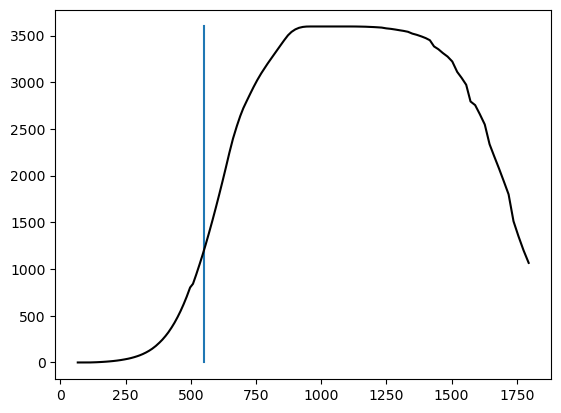

In [10]:
from openalea.archicrop.stics_io import get_stics_data

tec_file='D:/ArchiCrop/data/02NT18SorgV2D1_tec.xml'
plant_file='D:/ArchiCrop/data/sorgho_imp_M_v10_plt.xml'
stics_output_file='D:/ArchiCrop/data/mod_s02NT18SorgV2D1.sti'
# stics_output_file='D:/ArchiCrop/data/mod_s02NT18SorgV2D1_no_stress.sti'

density, daily_dynamics, lifespan, lifespan_early = get_stics_data(
    file_tec_xml=tec_file,  # Path to the STICS management XML file
    file_plt_xml=plant_file,  # Path to the STICS plant XML file
    stics_output_file=stics_output_file  # Path to the STICS output file
)

thermal_time = [value["Thermal time"] for value in daily_dynamics.values()]
leaf_area_plant = [value["Plant leaf area"] for value in daily_dynamics.values()]
sen_leaf_area_plant = [value["Plant senescent leaf area"] for value in daily_dynamics.values()]
height_canopy = [value["Plant height"] for value in daily_dynamics.values()]

for key, value in daily_dynamics.items():
    if value["Phenology"] == 'juvenile':
        next_key = key + 1
        if next_key in daily_dynamics and daily_dynamics[next_key]["Phenology"] == 'exponential':
            end_juv = thermal_time[key-1] + thermal_time[0]

    elif value["Phenology"] == 'exponential':
        next_key = key + 1
        if next_key in daily_dynamics and daily_dynamics[next_key]["Phenology"] == 'repro':
            end_veg = thermal_time[key-1] + thermal_time[0]
            index_end_veg = key - 1
            break

# plt.plot(thermal_time[:index_end_veg+2], leaf_area_plant[:index_end_veg+2], color="black")
plt.plot([end_juv, end_juv], [0.0, max(leaf_area_plant)])
plt.plot(thermal_time, [la-sen for la,sen in zip(leaf_area_plant, sen_leaf_area_plant)], color="black")
plt.show()

In [11]:
# Data points
# stics_output_file = 'mod_s02NT18SorgV2D1.sti'
# stics_output_file = 'mod_swheat.sti'
# # density = 10
# # inter_row = 0.4
# stics_output_data, density = read_sti_file(stics_output_file)
# thermal_time = [value["Thermal time"] for value in stics_output_data.values()]
# leaf_area_plant = [value["Plant leaf area"] for value in stics_output_data.values()]
# sen_leaf_area_plant = [value["Plant senescent leaf area"] for value in stics_output_data.values()]
# height_canopy = [value["Plant height"] for value in stics_output_data.values()]

# for key, value in stics_output_data.items():
#     next_key = key + 1
#     if next_key in stics_output_data and stics_output_data[next_key]["Phenology"] == 'repro':
#         end_veg = value["Thermal time"] + stics_output_data[1]["Thermal time"]
#         index_end_veg = key - 1
#         break

# plt.plot(thermal_time, [la-sen for la,sen in zip(leaf_area_plant, sen_leaf_area_plant)], color="blue")
# plt.plot(thermal_time, height_canopy, color="red")
# plt.show()

In [12]:
end_veg

1009.9955

$x \in [1,N]$  
$s: start$  
$e: end$  
$\forall \enspace 1 < ligul\_factor < 2$
$$S_{x=1} = S_{dyn}(e_1) - S_2 * \frac{e_1-s_2}{e_2-s_2} \qquad if \enspace x = 1$$  
$$S_x = S_{dyn}(e_x) - S_{x+1} * \frac{e_x-s_{x+1}}{e_{x+1}-s_{x+1}} - \sum_{i=1}^{x-1} S_i \qquad if \enspace 1 < x < N$$  
$$S_{x=N} = S_{dyn}(e_N) - \sum_{i=1}^{N-1} S_i \qquad if \enspace x = N$$  

 or  

$$S_{x=1} = S_{dyn}(e_1) - S_2 * \frac{ligul\_factor - 1}{ligul\_factor} \qquad if \enspace x = 1$$  
$$S_x = S_{dyn}(e_x) - S_{x+1} * \frac{ligul\_factor - 1}{ligul\_factor} - \sum_{i=1}^{x-1} S_i \qquad if \enspace 1 < x < N$$  
$$S_{x=N} = S_{dyn}(e_N) - \sum_{i=1}^{N-1} S_i \qquad if \enspace x = N$$ 

In [13]:
def resolve_system(N, ligul_factor, la_ends):
    
    A = np.zeros((N, N))
    B = np.zeros(N)

    # First equation (x=1)
    A[0, 0] = 1
    A[0, 1] = (ligul_factor - 1) / ligul_factor
    B[0] = la_ends[0]

    # Eauqtions for 1 < x < N
    for x in range(1, N-1):
        A[x, x] = 1
        A[x, x+1] = (ligul_factor - 1) / ligul_factor
        for i in range(x):
            A[x, i] = 1
        B[x] = la_ends[x]

    # Last equation (x=N)
    A[N-1, N-1] = 1
    for i in range(N-1):
        A[N-1, i] = 1
    B[N-1] = la_ends[N-1]
    

    # Resolution
    S = np.linalg.solve(A, B)
    return S

# phyllochron = 55
# ligul_factor = 1.6

# S = resolve_system(thermal_time, leaf_area_plant, phyllochron, ligul_factor)
# plt.plot(range(1,len(S)+1),S)
# plt.show()

In [14]:
import math

def compute_skew(leaf_areas, rank, nb_phy, rmax):
    # return math.exp(math.log(leaf_areas[rank-1])/(2*(rank/nb_phy - rmax)**2 + (rank/nb_phy - rmax)**3))
    return math.exp(math.log(leaf_areas[rank-1]/max(leaf_areas))/(2*(rank/nb_phy - rmax)**2 + (rank/nb_phy - rmax)**3))
    #     else:
    #         print("Rank", rank)
    #         print("Nb phy", nb_phy)
    #         print("Rmax", rmax)
    # else: 
    #     print("Nb phy", nb_phy)


def linear_leaf_growth_on_constraint(phyllochron, ligul_factor, thermal_time, leaf_area_plant, end_veg, index_end_veg, pot_factor):

    ligulochron = int(phyllochron * ligul_factor)
    nb_phy = math.floor((end_veg-thermal_time[0]-ligulochron)/phyllochron)

    leaf_area_plant = leaf_area_plant[:index_end_veg+1]
    thermal_time = thermal_time[:index_end_veg+1]
    spl = splrep(thermal_time, leaf_area_plant)
    # scaled_leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), width_ratios=[2,1])
    # ax1.scatter(thermal_time, leaf_area_plant, color="orange", label="STICS")
    ax1.plot(thermal_time, leaf_area_plant, linewidth=2, color="orange", label="Crop model")

 
    starts = []
    ends = []

    for i in range(nb_phy):
        start = i * phyllochron + int(thermal_time[0])
        end = start + ligulochron
        
        starts.append(start)
        ends.append(end)
  
    la_starts = splev(starts, spl)
    la_ends = splev(ends, spl)

    # leaf_areas = [0]*nb_phy
    # for j,(s,e) in enumerate(zip(la_starts,la_ends)):
    #     if j == 0:
    #         leaf_areas[j] += e
    #     elif 0 < j < len(la_starts)-1:
    #         leaf_areas[j] += e - sum(leaf_areas)
    #     else: 
    #         leaf_areas[j] += e - sum(leaf_areas)
    # # for j,(s,e) in enumerate(zip(la_starts,la_ends)):
    # #     if j < len(la_starts)-1:
    # #         leaf_areas[j] -= (ends[j]-starts[j+1])/(ends[j+1]-starts[j+1]) * leaf_areas[j+1]


    leaf_areas = resolve_system(nb_phy, ligul_factor, la_ends)
            
    growth = True

    if growth:
        for i,la in enumerate(leaf_areas):
            if i == 0:
                ax1.plot(np.linspace(starts[i], ends[i], 2), [0, leaf_areas[i]], color="#BF864D", linewidth=2, label="Linear leaf growth")
            else:
                ax1.plot(np.linspace(starts[i], ends[i], 2), [sum(leaf_areas[:i]), sum(leaf_areas[:i+1])], linewidth=2, color="#BF864D")

    else:
        for i,la in enumerate(leaf_areas):
            if i == 0:
                ax1.plot(np.linspace(starts[i], ends[i], 2), [leaf_areas[i]/2, leaf_areas[i]/2], color="#BF864D", linewidth=2, label="Leaf development")
            else:
                ax1.plot(np.linspace(starts[i], ends[i], 2), [(sum(leaf_areas[:i]) + sum(leaf_areas[:i+1]))/2, (sum(leaf_areas[:i]) + sum(leaf_areas[:i+1]))/2], linewidth=2, color="#BF864D")


    range_tt = range(round(thermal_time[0]), round(thermal_time[-1]))
    interp_la = splev(range_tt, spl)
    rates_la = [interp_la[i]-interp_la[i-1] if i > 0 else 0 for i in range(len(interp_la))]
    # ax3 = ax1.twinx()
    # ax3.plot(range_tt, rates_la, linestyle="--", color="black", label="Growth rate STICS")

    S = []
    for t in range(max(ends)):
        sum_temp = 0
        for i,(s,e) in enumerate(zip(starts,ends)):
            if s <= t < e:
                sum_temp += (t-s)/(e-s) * leaf_areas[i]
            elif t >= e:
                sum_temp += leaf_areas[i]
        S.append(sum_temp)
    
    # ax1.plot(starts, la_starts)
    # ax1.plot(ends, la_ends)
    ax1.set_xlabel("Thermal time (°C.d)", fontsize=24, fontname="Times New Roman")
    ax1.set_ylabel("Plant leaf surface (cm²)", fontsize=24, fontname="Times New Roman")
    # ax1.fill_between(range(int(thermal_time[0]),len(S)), [0]*(len(S)-int(thermal_time[0])), S[int(thermal_time[0]):], color="#BF864D", alpha=0.15, label="Cumulated sum of leaf areas")
    ax1.legend(fontsize=14)
    # ax3.legend()


    # fig2, ax2 = plt.subplots(figsize=(12,6))
    
    for i, la in enumerate(leaf_areas):
        if la == max(leaf_areas):
            id_max = i+1
            break

    # print(id_max-1/nb_phy)
    rmax_int = np.arange(max(0,(id_max-1)/nb_phy), min(1,(id_max+1)/nb_phy), 0.02)
    print("rmax int", rmax_int)
   
    leaf_areas_norm = [la/max(leaf_areas) for la in leaf_areas]
    
    skews_rmax = []
    for rank in range(1, nb_phy+1):
        for rmax in rmax_int:
            if rmax != rank/nb_phy and leaf_areas[rank-1] > 0:
                skew = compute_skew(rank=rank, nb_phy=nb_phy, rmax=rmax, leaf_areas=leaf_areas_norm)
                if 1e-10 < skew < 1.0:
                    skews_rmax.append((skew, rmax))

    # skew_int = [np.median(skews), max(skews)*1.3]
    # skews = [s[0] for s in skews_rmax]
    # skew_int = [min(skews), max(skews)]
    # print("Skews and rmax", skews_rmax)
    # plt.plot(range(len(skews)), skew_int)
    # plt.show()

    skew_int = []
    rejected_skews = []
    label_green_set = False
    label_grey_set = False
    for skew,rmax in skews_rmax:
        bell_shaped_leaf_areas = bell_shaped_dist(leaf_area_plant[-1]*pot_factor, nb_phy, rmax, skew)
        for i,bs in enumerate(bell_shaped_leaf_areas):
            if bs < leaf_areas[i]: #-(0.05*max(leaf_areas)):
                color = "grey"
                break
            else:
                color = "black"
        if color == "black" and not label_green_set:
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), color=color, alpha=0) #, label="Viable")
            label_green_set = True
        elif color == "black":
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), color=color, alpha=0)
        elif color == "grey" and not label_grey_set:
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), alpha=0, color=color) #, label="Non-viable")
            label_grey_set = True
        else:
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), alpha=0, color=color)
        if color == "black":
            skew_int.append(skew)
        else:
            rejected_skews.append(skew)
    
    # skew_int.sort()
    # print(skew_int)
    # rejected_skews.sort()
    # print(rejected_skews)
            
    # ax2.plot([id_max,id_max], [0,max(leaf_areas)], color="black", linestyle="--")
    # ax2.fill_between([id_max-1,id_max+1], [0]*2, [max(leaf_areas)*pot_factor**2]*2, color="green", alpha=0.15, label="Viable range for rmax")
    ax2.plot(leaf_areas, range(1,nb_phy+1), color="#BF864D", linestyle="-")
    ax2.scatter(leaf_areas, range(1,nb_phy+1), color="#BF864D", label="For linear leaf growth")
    ax2.set_ylabel("Leaf number", fontsize=24, fontname="Times New Roman")
    ax2.set_xlabel("Leaf surface (cm²)", fontsize=24, fontname="Times New Roman")
    ax2.legend(fontsize=14, loc="lower right")

    # print("bell shape :", sum(bell_shaped_leaf_areas))
    print("per leaf from stics :", sum(leaf_areas))
    print("for plant from stics :", leaf_area_plant[-1])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    today_str = date.today().strftime("%Y-%m-%d")
    os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
    if growth:
        plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/leaf_growth_phyllochron{phyllochron}_ligulochron{ligul_factor}_pot_factor_{pot_factor}.png")
    else:
        plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/leaf_development_phyllochron{phyllochron}_ligulochron{ligul_factor}_pot_factor_{pot_factor}.png")
    plt.show()

interact(linear_leaf_growth_on_constraint, 
         phyllochron = IntSlider(min=50,max=100,step=1,value=51), 
         ligul_factor = FloatSlider(min=1.0,max=3.0,step=0.1,value=1.6),
         thermal_time = fixed(thermal_time), 
         leaf_area_plant = fixed(leaf_area_plant), 
         end_veg = fixed(end_veg), 
         index_end_veg = fixed(index_end_veg),
         pot_factor = FloatSlider(min=1.0,max=2.0,step=0.05,value=1.4))

interactive(children=(IntSlider(value=51, description='phyllochron', min=50), FloatSlider(value=1.6, descripti…

<function __main__.linear_leaf_growth_on_constraint(phyllochron, ligul_factor, thermal_time, leaf_area_plant, end_veg, index_end_veg, pot_factor)>

In [15]:
def linear_leaf_growth_viable(phyllochron, ligul_factor, thermal_time, leaf_area_plant, end_veg, index_end_veg, pot_factor):

    ligulochron = int(phyllochron * ligul_factor)
    nb_phy = math.floor((end_veg-thermal_time[0]-ligulochron)/phyllochron)

    leaf_area_plant = leaf_area_plant[:index_end_veg+1]
    thermal_time = thermal_time[:index_end_veg+1]
    spl = splrep(thermal_time, leaf_area_plant)
    # scaled_leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), width_ratios=[2,1])
    # ax1.scatter(thermal_time, leaf_area_plant, color="orange", label="STICS")
    ax1.plot(thermal_time, leaf_area_plant, linewidth=2, color="orange", label="Crop model")

 
    starts = []
    ends = []

    for i in range(nb_phy):
        start = i * phyllochron + int(thermal_time[0])
        end = start + ligulochron
        
        starts.append(start)
        ends.append(end)
  
    la_starts = splev(starts, spl)
    la_ends = splev(ends, spl)

    # leaf_areas = [0]*nb_phy
    # for j,(s,e) in enumerate(zip(la_starts,la_ends)):
    #     if j == 0:
    #         leaf_areas[j] += e
    #     elif 0 < j < len(la_starts)-1:
    #         leaf_areas[j] += e - sum(leaf_areas)
    #     else: 
    #         leaf_areas[j] += e - sum(leaf_areas)
    # # for j,(s,e) in enumerate(zip(la_starts,la_ends)):
    # #     if j < len(la_starts)-1:
    # #         leaf_areas[j] -= (ends[j]-starts[j+1])/(ends[j+1]-starts[j+1]) * leaf_areas[j+1]


    leaf_areas = resolve_system(nb_phy, ligul_factor, la_ends)
            


    for i,la in enumerate(leaf_areas):
        if i == 0:
            ax1.plot(np.linspace(starts[i], ends[i], 2), [0, leaf_areas[i]], color="#BF864D", linewidth=2, label="Linear leaf growth")
        else:
            ax1.plot(np.linspace(starts[i], ends[i], 2), [sum(leaf_areas[:i]), sum(leaf_areas[:i+1])], linewidth=2, color="#BF864D")


    range_tt = range(round(thermal_time[0]), round(thermal_time[-1]))
    interp_la = splev(range_tt, spl)
    rates_la = [interp_la[i]-interp_la[i-1] if i > 0 else 0 for i in range(len(interp_la))]
    # ax3 = ax1.twinx()
    # ax3.plot(range_tt, rates_la, linestyle="--", color="black", label="Growth rate STICS")

    S = []
    for t in range(max(ends)):
        sum_temp = 0
        for i,(s,e) in enumerate(zip(starts,ends)):
            if s <= t < e:
                sum_temp += (t-s)/(e-s) * leaf_areas[i]
            elif t >= e:
                sum_temp += leaf_areas[i]
        S.append(sum_temp)
    
    # ax1.plot(starts, la_starts)
    # ax1.plot(ends, la_ends)
    ax1.set_xlabel("Thermal time (°C.d)", fontsize=24, fontname="Times New Roman")
    ax1.set_ylabel("Plant leaf surface (cm²)", fontsize=24, fontname="Times New Roman")
    # ax1.fill_between(range(int(thermal_time[0]),len(S)), [0]*(len(S)-int(thermal_time[0])), S[int(thermal_time[0]):], color="#BF864D", alpha=0.15, label="Cumulated sum of leaf areas")
    ax1.legend(fontsize=14)
    # ax3.legend()


    # fig2, ax2 = plt.subplots(figsize=(12,6))

    for i, la in enumerate(leaf_areas):
        if la == max(leaf_areas):
            id_max = i+1
            break

    # print(id_max-1/nb_phy)
    rmax_int = np.arange(max(0,(id_max-1)/nb_phy), min(1,(id_max+1)/nb_phy), 0.02)
    print("rmax int", rmax_int)
   
    leaf_areas_norm = [la/max(leaf_areas) for la in leaf_areas]
    
    skews_rmax = []
    for rank in range(1, nb_phy+1):
        for rmax in rmax_int:
            if rmax != rank/nb_phy and leaf_areas[rank-1] > 0:
                skew = compute_skew(rank=rank, nb_phy=nb_phy, rmax=rmax, leaf_areas=leaf_areas_norm)
                if 1e-10 < skew < 1.0:
                    skews_rmax.append((skew, rmax))

    # skew_int = [np.median(skews), max(skews)*1.3]
    # skews = [s[0] for s in skews_rmax]
    # skew_int = [min(skews), max(skews)]
    # print("Skews and rmax", skews_rmax)
    # plt.plot(range(len(skews)), skew_int)
    # plt.show()

    skew_int = []
    rejected_skews = []
    label_green_set = False
    label_grey_set = False
    for skew,rmax in skews_rmax:
        bell_shaped_leaf_areas = bell_shaped_dist(leaf_area_plant[-1]*pot_factor, nb_phy, rmax, skew)
        for i,bs in enumerate(bell_shaped_leaf_areas):
            if bs < leaf_areas[i]: #-(0.05*max(leaf_areas)):
                color = "grey"
                break
            else:
                color = "black"
        if color == "black" and not label_green_set:
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), color=color, label="Viable")
            label_green_set = True
        elif color == "black":
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), color=color)
        elif color == "grey" and not label_grey_set:
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), alpha=0.1, color=color, label="Non-viable")
            label_grey_set = True
        else:
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), alpha=0.1, color=color)
        if color == "black":
            skew_int.append(skew)
        else:
            rejected_skews.append(skew)

    # skew_int.sort()
    # print(skew_int)
    # rejected_skews.sort()
    # print(rejected_skews)
            
    # ax2.plot([id_max,id_max], [0,max(leaf_areas)], color="black", linestyle="--")
    # ax2.fill_between([id_max-1,id_max+1], [0]*2, [max(leaf_areas)*pot_factor**2]*2, color="green", alpha=0.15, label="Viable range for rmax")
    ax2.plot(leaf_areas, range(1,nb_phy+1), color="#BF864D", linestyle="-")
    ax2.scatter(leaf_areas, range(1,nb_phy+1), color="#BF864D", label="For linear leaf growth")
    ax2.set_ylabel("Leaf number", fontsize=24, fontname="Times New Roman")
    ax2.set_xlabel("Leaf surface (cm²)", fontsize=24, fontname="Times New Roman")
    ax2.legend(fontsize=14)

    print("bell shape :", sum(bell_shaped_leaf_areas))
    print("per leaf from stics :", sum(leaf_areas))
    print("for plant from stics :", leaf_area_plant[-1])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    today_str = date.today().strftime("%Y-%m-%d")
    os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
    plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/leaf_growth_viable_phyllochron{phyllochron}_ligulochron{ligul_factor}_pot_factor_{pot_factor}.png")
    plt.show()

interact(linear_leaf_growth_viable, 
         phyllochron = IntSlider(min=30,max=80,step=1,value=51), 
         ligul_factor = FloatSlider(min=1.0,max=3.0,step=0.1,value=1.6),
         thermal_time = fixed(thermal_time), 
         leaf_area_plant = fixed(leaf_area_plant), 
         end_veg = fixed(end_veg), 
         index_end_veg = fixed(index_end_veg),
         pot_factor = FloatSlider(min=1.0,max=2.0,step=0.05,value=1.4))

interactive(children=(IntSlider(value=51, description='phyllochron', max=80, min=30), FloatSlider(value=1.6, d…

<function __main__.linear_leaf_growth_viable(phyllochron, ligul_factor, thermal_time, leaf_area_plant, end_veg, index_end_veg, pot_factor)>

In [16]:
from openalea.archicrop.archicrop import ArchiCrop

def linear_leaf_growth_and_pot(phyllochron, ligul_factor, thermal_time, leaf_area_plant, end_veg, index_end_veg, pot_factor):

    ligulochron = int(phyllochron * ligul_factor)
    nb_phy = math.floor((end_veg-thermal_time[0]-ligulochron)/phyllochron)

    leaf_area_plant = leaf_area_plant[:index_end_veg+1]
    thermal_time = thermal_time[:index_end_veg+1]
    spl = splrep(thermal_time, leaf_area_plant)
    # scaled_leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), width_ratios=[2,1])
    # ax1.scatter(thermal_time, leaf_area_plant, color="orange", label="STICS")
    ax1.plot(thermal_time, leaf_area_plant, linewidth=4, color="orange", label="Crop model")

 
    starts = []
    ends = []

    for i in range(nb_phy):
        start = i * phyllochron + int(thermal_time[0])
        end = start + ligulochron
        
        starts.append(start)
        ends.append(end)
  
    la_starts = splev(starts, spl)
    la_ends = splev(ends, spl)

    # leaf_areas = [0]*nb_phy
    # for j,(s,e) in enumerate(zip(la_starts,la_ends)):
    #     if j == 0:
    #         leaf_areas[j] += e
    #     elif 0 < j < len(la_starts)-1:
    #         leaf_areas[j] += e - sum(leaf_areas)
    #     else: 
    #         leaf_areas[j] += e - sum(leaf_areas)
    # # for j,(s,e) in enumerate(zip(la_starts,la_ends)):
    # #     if j < len(la_starts)-1:
    # #         leaf_areas[j] -= (ends[j]-starts[j+1])/(ends[j+1]-starts[j+1]) * leaf_areas[j+1]


    leaf_areas = resolve_system(nb_phy, ligul_factor, la_ends)
            
    # for i,la in enumerate(leaf_areas):
    #     if i == 0:
    #         ax1.plot(np.linspace(starts[i], ends[i], 2), [0, leaf_areas[i]], color="#BF864D", linewidth=2, label="Linear leaf growth")
    #     else:
    #         ax1.plot(np.linspace(starts[i], ends[i], 2), [sum(leaf_areas[:i]), sum(leaf_areas[:i+1])], linewidth=2, color="#BF864D")

    range_tt = range(round(thermal_time[0]), round(thermal_time[-1]))
    interp_la = splev(range_tt, spl)
    rates_la = [interp_la[i]-interp_la[i-1] if i > 0 else 0 for i in range(len(interp_la))]
    # ax3 = ax1.twinx()
    # ax3.plot(range_tt, rates_la, linestyle="--", color="black", label="Growth rate STICS")

    S = []
    for t in range(max(ends)):
        sum_temp = 0
        for i,(s,e) in enumerate(zip(starts,ends)):
            if s <= t < e:
                sum_temp += (t-s)/(e-s) * leaf_areas[i]
            elif t >= e:
                sum_temp += leaf_areas[i]
        S.append(sum_temp)
    
    # ax1.plot(starts, la_starts)
    # ax1.plot(ends, la_ends)
    ax1.set_xlabel("Thermal time (°C.d)", fontsize=24, fontname="Times New Roman")
    ax1.set_ylabel("Plant leaf surface (cm²)", fontsize=24, fontname="Times New Roman")
    # ax1.fill_between(range(int(thermal_time[0]),len(S)), [0]*(len(S)-int(thermal_time[0])), S[int(thermal_time[0]):], color="#BF864D", alpha=0.15, label="Cumulated sum of leaf areas")
    
    # ax3.legend()


    # fig2, ax2 = plt.subplots(figsize=(12,6))
    
    for i, la in enumerate(leaf_areas):
        if la == max(leaf_areas):
            id_max = i+1
            break

    # print(id_max-1/nb_phy)
    rmax_int = np.arange(max(0,(id_max-1)/nb_phy), min(1,(id_max+1)/nb_phy), 0.02)
    print("rmax int", rmax_int)
   
    leaf_areas_norm = [la/max(leaf_areas) for la in leaf_areas]
    
    skews_rmax = {}
    id = 0
    for rank in range(1, nb_phy+1):
        for rmax in rmax_int:
            if rmax != rank/nb_phy and leaf_areas[rank-1] > 0:
                skew = compute_skew(rank=rank, nb_phy=nb_phy, rmax=rmax, leaf_areas=leaf_areas_norm)
                if 1e-10 < skew < 1.0:
                    skews_rmax[id] = (skew, rmax)
                    id += 1

    # skew_int = [np.median(skews), max(skews)*1.3]
    # skews = [s[0] for s in skews_rmax]
    # skew_int = [min(skews), max(skews)]
    # print("Skews and rmax", skews_rmax)
    # plt.plot(range(len(skews)), skew_int)
    # plt.show()

    skew_int = []
    rejected_skews = []
    label_green_set = False
    label_grey_set = False
    mtgs = {}
    # realized_la = {}
    for id,(skew,rmax) in skews_rmax.items():
        bell_shaped_leaf_areas = bell_shaped_dist(leaf_area_plant[-1]*pot_factor, nb_phy, rmax, skew)
        for i,bs in enumerate(bell_shaped_leaf_areas):
            if bs < leaf_areas[i]: #-(0.05*max(leaf_areas)):
                color = "grey"
                break
            else:
                color = "black"
        if color == "black":
            S = []
            for t in range(max(ends)):
                sum_temp = 0
                for i,(s,e) in enumerate(zip(starts,ends)):
                    if s <= t < e:
                        sum_temp += (t-s)/(e-s) * bell_shaped_leaf_areas[i]
                    elif t >= e:
                        sum_temp += bell_shaped_leaf_areas[i]
                S.append(sum_temp)

            
            plant = ArchiCrop(daily_dynamics=daily_dynamics, leaf_area=leaf_area_plant[-1]*pot_factor, height=height_canopy[-1]*pot_factor, 
                                nb_phy=nb_phy, phyllochron=phyllochron, leaf_duration=ligul_factor)
            plant.generate_potential_plant()
            growing_plant = plant.grow_plant(rate=False, distribution_function=equal_dist)
            growing_plant_mtg = list(growing_plant.values())
            mtgs[id] = growing_plant_mtg
             
        if color == "black" and not label_green_set:
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), color=color, label="Viable")
            ax1.plot(range(int(thermal_time[0]),len(S)), S[int(thermal_time[0]):], color=color, label="Viable")
            ax1.plot(thermal_time,[sum(la 
                                for la in gp.properties()["visible_leaf_area"].values()) 
                                for gp in growing_plant_mtg[:index_end_veg+1]], color="green", label="Simulated")
            label_green_set = True
        elif color == "black":
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), color=color)
            ax1.plot(range(int(thermal_time[0]),len(S)), S[int(thermal_time[0]):], color=color)
            ax1.plot(thermal_time,[sum(la 
                                for la in gp.properties()["visible_leaf_area"].values()) 
                                for gp in growing_plant_mtg[:index_end_veg+1]], color="green")
        elif color == "grey" and not label_grey_set:
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), alpha=0, color=color) #, label="Non-viable")
            label_grey_set = True
        else:
            ax2.plot(bell_shaped_leaf_areas, range(1,nb_phy+1), alpha=0, color=color)
        if color == "black":
            skew_int.append(skew)
        else:
            rejected_skews.append(skew)

    # skew_int.sort()
    # print(skew_int)
    # rejected_skews.sort()
    # print(rejected_skews)
            
    # ax2.plot([id_max,id_max], [0,max(leaf_areas)], color="black", linestyle="--")
    # ax2.fill_between([id_max-1,id_max+1], [0]*2, [max(leaf_areas)*pot_factor**2]*2, color="green", alpha=0.15, label="Viable range for rmax")
    # ax2.plot(leaf_areas, range(1,nb_phy+1), color="#BF864D", linestyle="-")
    # ax2.scatter(leaf_areas, range(1,nb_phy+1), color="#BF864D", label="For linear leaf growth")


    first = True
    for id in mtgs:
        visible_leaf_areas = []

        for leaf in mtgs[id][-32].properties()["visible_leaf_area"]:
            visible_leaf_areas.append(mtgs[id][-32].properties()["visible_leaf_area"][leaf])
        # bell_shape = bell_shaped_dist(params_sets[id]['leaf_area'], params_sets[id]['nb_phy'], params_sets[id]['rmax'], params_sets[id]['skew'])

        if first:
            ax2.plot(visible_leaf_areas, range(1, nb_phy + 1), color="green", label="Simulated")
            first = False
        else:
            ax2.plot(visible_leaf_areas, range(1, nb_phy + 1), color="green")



    ax2.plot(leaf_areas, range(1,nb_phy+1), color="#BF864D", linestyle="-")
    ax2.scatter(leaf_areas, range(1,nb_phy+1), color="#BF864D", label="Linear")
    ax2.set_ylabel("Leaf number", fontsize=24, fontname="Times New Roman")
    ax2.set_xlabel("Leaf surface (cm²)", fontsize=24, fontname="Times New Roman")
    ax2.legend(fontsize=14, loc="lower right")
    ax1.legend(fontsize=14)


    print("bell shape :", sum(bell_shaped_leaf_areas))
    print("per leaf from stics :", sum(leaf_areas))
    print("for plant from stics :", leaf_area_plant[-1])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    today_str = date.today().strftime("%Y-%m-%d")
    os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
    plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/leaf_growth_and pot_phyllochron{phyllochron}_ligulochron{ligul_factor}_pot_factor_{pot_factor}.png")
    plt.show()

interact(linear_leaf_growth_and_pot, 
         phyllochron = IntSlider(min=30,max=80,step=1,value=51), 
         ligul_factor = FloatSlider(min=1.0,max=3.0,step=0.1,value=1.6),
         thermal_time = fixed(thermal_time), 
         leaf_area_plant = fixed(leaf_area_plant), 
         end_veg = fixed(end_veg), 
         index_end_veg = fixed(index_end_veg),
         pot_factor = FloatSlider(min=1.0,max=2.0,step=0.05,value=1.4))

interactive(children=(IntSlider(value=51, description='phyllochron', max=80, min=30), FloatSlider(value=1.6, d…

<function __main__.linear_leaf_growth_and_pot(phyllochron, ligul_factor, thermal_time, leaf_area_plant, end_veg, index_end_veg, pot_factor)>

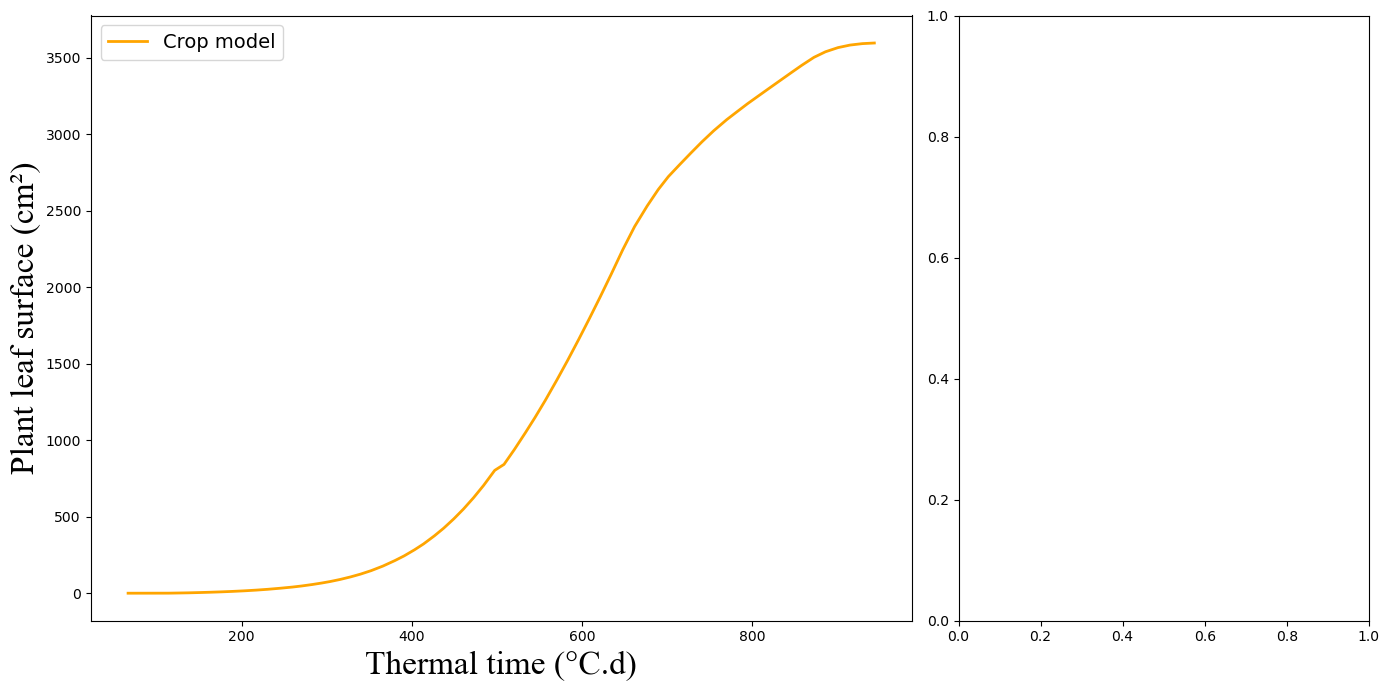

In [17]:
leaf_area_plant = leaf_area_plant[:index_end_veg+1]
thermal_time = thermal_time[:index_end_veg+1]

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), width_ratios=[2,1])
# ax1.scatter(thermal_time, leaf_area_plant, color="orange", label="STICS")
ax1.plot(thermal_time, leaf_area_plant, linewidth=2, color="orange", label="Crop model")


# ax1.plot(starts, la_starts)
# ax1.plot(ends, la_ends)
ax1.set_xlabel("Thermal time (°C.d)", fontsize=24, fontname="Times New Roman")
ax1.set_ylabel("Plant leaf surface (cm²)", fontsize=24, fontname="Times New Roman")
# ax1.fill_between(range(int(thermal_time[0]),len(S)), [0]*(len(S)-int(thermal_time[0])), S[int(thermal_time[0]):], color="#BF864D", alpha=0.15, label="Cumulated sum of leaf areas")
ax1.legend(fontsize=14)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
today_str = date.today().strftime("%Y-%m-%d")
os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/leaf_area_plant.png")
plt.show()

In [18]:
import math

def compute_skew(leaf_areas, rank, nb_phy, rmax):
    # return math.exp(math.log(leaf_areas[rank-1])/(2*(rank/nb_phy - rmax)**2 + (rank/nb_phy - rmax)**3))
    return math.exp(math.log(leaf_areas[rank-1]/max(leaf_areas))/(2*(rank/nb_phy - rmax)**2 + (rank/nb_phy - rmax)**3))
    #     else:
    #         print("Rank", rank)
    #         print("Nb phy", nb_phy)
    #         print("Rmax", rmax)
    # else: 
    #     print("Nb phy", nb_phy)


def linear_leaf_growth_on_constraint(phyllochron, ligul_factor, thermal_time, leaf_area_plant, end_veg, index_end_veg, pot_factor):

    ligulochron = int(phyllochron * ligul_factor)
    nb_phy = round((end_veg-thermal_time[0]-ligulochron)/phyllochron)

    leaf_area_plant = leaf_area_plant[:index_end_veg+1]
    thermal_time = thermal_time[:index_end_veg+1]
    spl = splrep(thermal_time, leaf_area_plant)
    # scaled_leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    ax1.plot(thermal_time, leaf_area_plant, linewidth=2, color="black", label="Crop model")

 
    starts = []
    ends = []

    for i in range(nb_phy):
        start = i * phyllochron + int(thermal_time[0])
        end = start + ligulochron
        
        starts.append(start)
        ends.append(end)
  
    la_starts = splev(starts, spl)
    la_ends = splev(ends, spl)

    # leaf_areas = [0]*nb_phy
    # for j,(s,e) in enumerate(zip(la_starts,la_ends)):
    #     if j == 0:
    #         leaf_areas[j] += e
    #     elif 0 < j < len(la_starts)-1:
    #         leaf_areas[j] += e - sum(leaf_areas)
    #     else: 
    #         leaf_areas[j] += e - sum(leaf_areas)
    # # for j,(s,e) in enumerate(zip(la_starts,la_ends)):
    # #     if j < len(la_starts)-1:
    # #         leaf_areas[j] -= (ends[j]-starts[j+1])/(ends[j+1]-starts[j+1]) * leaf_areas[j+1]


    leaf_areas = resolve_system(nb_phy, ligul_factor, la_ends)
            

    for i,la in enumerate(leaf_areas):
        if i == 0:
            ax1.plot(np.linspace(starts[i], ends[i], 2), [0, leaf_areas[i]], color="orange", linewidth=2, label="Area of each leaf")
        else:
            ax1.plot(np.linspace(starts[i], ends[i], 2), [sum(leaf_areas[:i]), sum(leaf_areas[:i+1])], linewidth=2, color="orange")

    range_tt = range(round(thermal_time[0]), round(thermal_time[-1]))
    interp_la = splev(range_tt, spl)
    rates_la = [interp_la[i]-interp_la[i-1] if i > 0 else 0 for i in range(len(interp_la))]
    # ax3 = ax1.twinx()
    # ax3.plot(range_tt, rates_la, linestyle="--", color="black", label="Growth rate STICS")

    S = []
    for t in range(max(ends)):
        sum_temp = 0
        for i,(s,e) in enumerate(zip(starts,ends)):
            if s <= t < e:
                sum_temp += (t-s)/(e-s) * leaf_areas[i]
            elif t >= e:
                sum_temp += leaf_areas[i]
        S.append(sum_temp)
    
    # ax1.plot(starts, la_starts)
    # ax1.plot(ends, la_ends)
    ax1.set_xlabel("Thermal time (°C.d)", fontsize=16, fontname="Times New Roman")
    ax1.set_ylabel("Leaf area (cm²)", fontsize=16, fontname="Times New Roman")
    ax1.fill_between(range(len(S)), [0]*len(S), S, color="orange", alpha=0.15, label="Cumulated sum of leaf areas")
    ax1.legend()
    # ax3.legend()


    # fig2, ax2 = plt.subplots(figsize=(12,6))
    
    for i, la in enumerate(leaf_areas):
        if la == max(leaf_areas):
            id_max = i+1
            break

    # print(id_max-1/nb_phy)
    rmax_int = np.arange(max(0,(id_max-1)/nb_phy), min(1,(id_max+1)/nb_phy), 0.02)
    print("rmax int", rmax_int)
   
    leaf_areas_norm = [la/max(leaf_areas) for la in leaf_areas]
    
    skews_rmax = []
    for rank in range(1, nb_phy+1):
        for rmax in rmax_int:
            if rmax != rank/nb_phy and leaf_areas[rank-1] > 0:
                skew = compute_skew(rank=rank, nb_phy=nb_phy, rmax=rmax, leaf_areas=leaf_areas_norm)
                if 1e-10 < skew < 1.0:
                    skews_rmax.append((skew, rmax))

    # skew_int = [np.median(skews), max(skews)*1.3]
    # skews = [s[0] for s in skews_rmax]
    # skew_int = [min(skews), max(skews)]
    # print("Skews and rmax", skews_rmax)
    # plt.plot(range(len(skews)), skew_int)
    # plt.show()

    skew_int = []
    rejected_skews = []
    label_green_set = False
    label_grey_set = False
    for skew,rmax in skews_rmax:
        bell_shaped_leaf_areas = bell_shaped_dist(leaf_area_plant[-1]*pot_factor, nb_phy, rmax, skew)
        for i,bs in enumerate(bell_shaped_leaf_areas):
            if bs < leaf_areas[i]:
                color = "grey"
                break
            else:
                color = "green"
        if color == "green" and not label_green_set:
            ax2.plot(range(1,nb_phy+1), bell_shaped_leaf_areas, alpha=0.3, color=color, label="Bell shapes with good (rmax, skew)")
            label_green_set = True
        elif color == "green":
            ax2.plot(range(1,nb_phy+1), bell_shaped_leaf_areas, alpha=0.3, color=color)
        elif color == "grey" and not label_grey_set:
            ax2.plot(range(1,nb_phy+1), bell_shaped_leaf_areas, alpha=0.1, color=color, label="Rejected bell shapes (rmax, skew)")
            label_grey_set = True
        else:
            ax2.plot(range(1,nb_phy+1), bell_shaped_leaf_areas, alpha=0.1, color=color)
        if color == "green":
            skew_int.append(skew)
        else:
            rejected_skews.append(skew)

    skew_int.sort()
    print(skew_int)
    rejected_skews.sort()
    # print(rejected_skews)
            
    # ax2.plot([id_max,id_max], [0,max(leaf_areas)], color="black", linestyle="--")
    ax2.fill_between([id_max-1,id_max+1], [0]*2, [max(leaf_areas)*pot_factor**2]*2, color="green", alpha=0.15, label="rmax range")
    ax2.plot(range(1,nb_phy+1), leaf_areas, color="orange", linestyle="-")
    ax2.scatter(range(1,nb_phy+1), leaf_areas, color="orange")
    ax2.set_xlabel("Nb of phytomers", fontsize=16, fontname="Times New Roman")
    ax2.set_ylabel("Leaf area (cm²)", fontsize=16, fontname="Times New Roman")
    ax2.legend()

    print("bell shape :", sum(bell_shaped_leaf_areas))
    print("per leaf from stics :", sum(leaf_areas))
    print("for plant from stics :", leaf_area_plant[-1])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    today_str = date.today().strftime("%Y-%m-%d")
    os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
    plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/leaf_growth_phyllochron{phyllochron}_ligulochron{ligul_factor}_pot_factor_{pot_factor}.png")
    plt.show()

interact(linear_leaf_growth_on_constraint, 
         phyllochron = IntSlider(min=30,max=70,step=1,value=55), 
         ligul_factor = FloatSlider(min=1.0,max=3.0,step=0.1,value=1.6),
         thermal_time = fixed(thermal_time), 
         leaf_area_plant = fixed(leaf_area_plant), 
         end_veg = fixed(end_veg), 
         index_end_veg = fixed(index_end_veg),
         pot_factor = FloatSlider(min=1.0,max=2.0,step=0.05,value=1.5))

interactive(children=(IntSlider(value=55, description='phyllochron', max=70, min=30), FloatSlider(value=1.6, d…

<function __main__.linear_leaf_growth_on_constraint(phyllochron, ligul_factor, thermal_time, leaf_area_plant, end_veg, index_end_veg, pot_factor)>

In [19]:
import numpy as np
from scipy.optimize import minimize_scalar

def bell_shaped_dist(leaf_area, nb_phy, rmax, skew):
    k = -np.log(skew) * rmax
    r = np.linspace(1.0 / nb_phy, 1, nb_phy)
    relative_area = np.exp(-k / rmax * (2 * (r - rmax) ** 2 + (r - rmax) ** 3))
    total_area = sum(relative_area)
    normalized_leaf_areas = [area / total_area for area in relative_area]
    return [leaf_area * la for la in normalized_leaf_areas]

def infer_skew(observed, leaf_area, nb_phy, rmax):
    # Normalize observed to relative areas
    observed_rel = np.array(observed) / sum(observed)

    def loss(skew):
        pred_rel = np.array(bell_shaped_dist(leaf_area, nb_phy, rmax, skew)) / leaf_area
        return np.sum((pred_rel - observed_rel)**2)

    res = minimize_scalar(loss, bounds=(1e-6, 0.999999), method="bounded")
    return res.x

# Infer skew back
estimated_skew = infer_skew(leaf_areas, leaf_area=100, nb_phy=10, rmax=0.5)
print("Estimated skew:", estimated_skew)

Estimated skew: 0.9999930391509351


$s_\min \le s \le s_\max, \quad s_\min = \max_{i,j:\phi_i>\phi_j} \exp\left( \frac{\ln((A^{-1}B)_i / (A^{-1}B)_j)}{\phi_i-\phi_j} \right), \quad s_\max = \min_{i,j:\phi_i<\phi_j} \exp\left( \frac{\ln((A^{-1}B)_i / (A^{-1}B)_j)}{\phi_i-\phi_j} \right)$

$\boxed{s_\min(p,l,r) \le s \le s_\max(p,l,r)}$

$w_\min = \frac{S}{\sum_k C_k(s_\max)}, \quad w_\max = \frac{S}{\sum_k C_k(s_\min)}$

$\boxed{w_\min(p,l,r) = \frac{S}{\sum_k C_k(s_\max)}, \quad w_\max(p,l,r) = \frac{S}{\sum_k C_k(s_\min)}}$

$p \le \min_i f^{-1}\Big( \frac{w_\max C_i - \sum_{j \ne k} (A^{-1})_{ij} f((j+l)p)}{(A^{-1})_{ik}} \Big) / (k+l)$

$p \le p_{\max,i}(l,r,s) = f^{-1} \Bigg( \frac{w_\max C_i - \sum_{j \ne k} (A^{-1})_{ij} f((j+l)p)}{(A^{-1})_{ik}} \Bigg) / (k+l)$

$\boxed{0 < p \le p_\max(l,r,s) = \min_i p_{\max,i}(l,r,s)}$

$l \le l_{\max,i}(p,r,s) \quad \implies \quad \boxed{0 < l \le l_\max(p,r,s) = \min_i l_{\max,i}(p,r,s)}$

$r_\min \le r \le r_\max, \quad r_\min = \max_{i,j} \text{roots of } \phi_i(r,N)-\phi_j(r,N) \ge \frac{\ln((A^{-1}B)_i/(A^{-1}B)_j)}{\ln s_\max},\quad \text{etc.}$

$r_\min \le r \le r_\max, \quad \phi_i(r,N) - \phi_j(r,N) \ge \frac{\ln((A^{-1}B)_i / (A^{-1}B)_j)}{\ln s_\max}, \quad \text{etc.}$

$\phi_i(r) - \phi_j(r) \ge \frac{\ln \frac{\sum_k (A^{-1})_{ik} B_k}{\sum_k (A^{-1})_{jk} B_k}}{\ln s_\max}, \quad \text{for } \phi_i > \phi_j \phi_i(r) - \phi_j(r) \le \frac{\ln \frac{\sum_k (A^{-1})_{ik} B_k}{\sum_k (A^{-1})_{jk} B_k}}{\ln s_\min}, \quad \text{for } \phi_i < \phi_j$

$\boxed{r_\min(l,p,s) \le r \le r_\max(l,p,s)}$


$\begin{aligned} N &= \left\lceil \frac{B_N - p l}{p} \right\rceil,\\ s &\in [s_\min(p,l,r), s_\max(p,l,r)],\\ w &\in [w_\min(p,l,r), w_\max(p,l,r)],\\ p &\in (0, p_\max(l,r,s)],\\ l &\in (0, l_\max(p,r,s)],\\ r &\in [r_\min(l,p,s), r_\max(l,p,s)]. \end{aligned}$

In [20]:
def linear_leaf_growth(phyllochron, ligul_factor, Smax, nb_phy, rmax, skew):

    ligulochron = int(phyllochron * ligul_factor)

    scaled_leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

    fig, ax1 = plt.subplots()

    starts = []
    ends = []

    for i in range(nb_phy):
        start = i * phyllochron + int(thermal_time[0])
        end = start + ligulochron
        
        starts.append(start)
        ends.append(end)
        prev = sum(scaled_leaf_areas[:i]) if i > 0 else 0
        curr = sum(scaled_leaf_areas[:i+1]) if i < len(scaled_leaf_areas) else sum(scaled_leaf_areas)
        ax1.plot(np.linspace(start, end, 2), [prev,curr], color="g")
        # ax1.text(end-4, scaled_leaf_areas[i]+3, f'{i+1}', fontsize = 10)

    S = []
    
    for t in range(max(ends)):
        sum_temp = 0
        for i,(s,e) in enumerate(zip(starts,ends)):
            if s <= t < e:
                sum_temp += (t-s)/(e-s) * scaled_leaf_areas[i]
            elif t >= e:
                sum_temp += scaled_leaf_areas[i]
        S.append(sum_temp)                
    
   
    ax1.set_xlabel("Thermal time (°C.d)")
    ax1.set_ylabel("Leaf area (cm²)")
    # ax1.fill_between([end/1.95,end/1.95+25], 0, max(scaled_leaf_areas), color="grey", alpha=0.4)
             
    # ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    # ax2.set_ylabel("Plant leaf area (cm²)")
    ax1.fill_between(range(len(S)), [0]*len(S), S, color="g", alpha=0.2)

    plt.plot(thermal_time[:index_end_veg+2], leaf_area_plant[:index_end_veg+2], color="black")
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


nb_phy = 8
Smax = max(leaf_area_plant)
rmax = 0.9
skew = 0.009
phyllochron = 44
ligulochron = int(phyllochron * 1.6)

interact(linear_leaf_growth, 
         phyllochron = IntSlider(min=30,max=60,step=1,value=55), 
         ligul_factor = FloatSlider(min=1.0,max=3.0,step=0.1,value=1.6), 
         nb_phy = IntSlider(min=8,max=25,step=1,value=12),
         Smax = fixed(max(leaf_area_plant)),
         rmax = FloatSlider(min=0.5,max=1.0,step=0.05,value=0.8),
         skew = FloatSlider(min=0.0005,max=0.2,step=0.0005,value=0.01))

interactive(children=(IntSlider(value=55, description='phyllochron', max=60, min=30), FloatSlider(value=1.6, d…

<function __main__.linear_leaf_growth(phyllochron, ligul_factor, Smax, nb_phy, rmax, skew)>

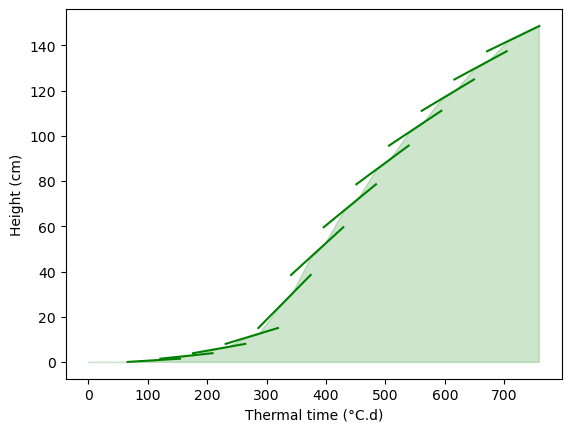

interactive(children=(IntSlider(value=55, description='phyllochron', max=70, min=30), FloatSlider(value=1.6, d…

<function __main__.linear_stem_growth(phyllochron, ligul_factor, Hmax, nb_phy, q1, q2, nb_short_phy, short_phy_height)>

In [21]:
def linear_stem_growth(phyllochron, ligul_factor, Hmax, nb_phy, q1, q2, nb_short_phy, short_phy_height):

    ligulochron = int(phyllochron * ligul_factor)

    u0 = 15
    first_ligule_heights = geometric_dist(u0, nb_short_phy, q1, 0)
    print(first_ligule_heights)
    ligule_heights = geometric_dist(Hmax-u0, nb_phy-nb_short_phy, q2, first_ligule_heights[-1]-first_ligule_heights[-2])
    ligule_heights = np.array([h+first_ligule_heights[-1] for h in ligule_heights])
    internode_heights = [h - first_ligule_heights[i-1] if i>0 else h 
                         for i,h in enumerate(first_ligule_heights)] + [h - ligule_heights[i-1] if i>0 else h-first_ligule_heights[-1] 
                                                                        for i,h in enumerate(ligule_heights)]
    
    fig, ax1 = plt.subplots()

    starts = []
    ends = []

    for i in range(nb_phy):
        start = i * phyllochron + int(thermal_time[0])
        end = start + ligulochron
        
        starts.append(start)
        ends.append(end)
        prev = sum(internode_heights[:i]) if i > 0 else 0
        curr = sum(internode_heights[:i+1]) if i < len(internode_heights) else sum(internode_heights)
        ax1.plot(np.linspace(start, end, 2), [prev,curr], color="g")
        # ax1.text(end-4, internode_heights[i]+3, f'{i+1}', fontsize = 10)

    S = []
    for t in range(max(ends)):
        sum_temp = 0
        for i,(s,e) in enumerate(zip(starts,ends)):
            if s <= t < e:
                sum_temp += (t-s)/(e-s) * internode_heights[i]
            elif t >= e:
                sum_temp += internode_heights[i]
        S.append(sum_temp)                
    
   
    ax1.set_xlabel("Thermal time (°C.d)")
    ax1.set_ylabel("Height (cm)")
    # ax1.fill_between([end/1.95,end/1.95+25], 0, max(scaled_leaf_areas), color="grey", alpha=0.4)
             
    # ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    # ax2.set_ylabel("Plant height (cm)")
    ax1.fill_between(range(len(S)), [0]*len(S), S, color="g", alpha=0.2)

    plt.plot(thermal_time[:index_end_veg+2], height_canopy[:index_end_veg+2], color="black")
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

interact(linear_stem_growth, 
         phyllochron = IntSlider(min=30,max=70,step=1,value=55), 
         ligul_factor = FloatSlider(min=1.0,max=3.0,step=0.1,value=1.6), 
         nb_phy = IntSlider(min=8,max=25,step=1,value=12),
         Hmax = fixed(max(height_canopy)),
         q1 = FloatSlider(min=0.7,max=2.0,step=0.05,value=1.7),
         q2 = FloatSlider(min=0.7,max=1.3,step=0.05,value=0.9),
         nb_short_phy = IntSlider(min=2,max=10,step=1,value=4),
         short_phy_height = FloatSlider(min=2,max=5,step=1,value=3))

In [22]:
def linear_stem_growth_viable(phyllochron, ligul_factor, thermal_time, height_plant, end_veg, index_end_veg, pot_factor):

    ligulochron = int(phyllochron * ligul_factor)
    nb_phy = math.floor((end_veg-thermal_time[0]-ligulochron)/phyllochron)

    height_plant = height_plant[:index_end_veg+1]
    thermal_time = thermal_time[:index_end_veg+1]
    spl = splrep(thermal_time, height_plant)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), width_ratios=[2,1])
    ax1.plot(thermal_time, height_plant, linewidth=2, color="orange", label="Crop model")

 
    starts = []
    ends = []

    for i in range(nb_phy):
        start = i * phyllochron + int(thermal_time[0])
        end = start + ligulochron
        
        starts.append(start)
        ends.append(end)
  
    h_starts = splev(starts, spl)
    h_ends = splev(ends, spl)

    heights = resolve_system(nb_phy, ligul_factor, h_ends)
            


    for i,la in enumerate(heights):
        if i == 0:
            ax1.plot(np.linspace(starts[i], ends[i], 2), [0, heights[i]], color="#BF864D", linewidth=2, label="Linear stem growth")
        else:
            ax1.plot(np.linspace(starts[i], ends[i], 2), [sum(heights[:i]), sum(heights[:i+1])], linewidth=2, color="#BF864D")


    range_tt = range(round(thermal_time[0]), round(thermal_time[-1]))
    interp_h = splev(range_tt, spl)
    rates_h = [interp_h[i]-interp_h[i-1] if i > 0 else 0 for i in range(len(interp_h))]
    # ax3 = ax1.twinx()
    # ax3.plot(range_tt, rates_la, linestyle="--", color="black", label="Growth rate STICS")

    H = []
    for t in range(max(ends)):
        sum_temp = 0
        for i,(s,e) in enumerate(zip(starts,ends)):
            if s <= t < e:
                sum_temp += (t-s)/(e-s) * heights[i]
            elif t >= e:
                sum_temp += heights[i]
        H.append(sum_temp)
    
    # ax1.plot(starts, la_starts)
    # ax1.plot(ends, la_ends)
    ax1.set_xlabel("Thermal time (°C.d)", fontsize=24, fontname="Times New Roman")
    ax1.set_ylabel("Plant height (cm²)", fontsize=24, fontname="Times New Roman")
    # ax1.fill_between(range(int(thermal_time[0]),len(S)), [0]*(len(S)-int(thermal_time[0])), S[int(thermal_time[0]):], color="#BF864D", alpha=0.15, label="Cumulated sum of leaf areas")
    ax1.legend(fontsize=14)
    # ax3.legend()

            
    # ax2.plot([id_max,id_max], [0,max(leaf_areas)], color="black", linestyle="--")
    # ax2.fill_between([id_max-1,id_max+1], [0]*2, [max(leaf_areas)*pot_factor**2]*2, color="green", alpha=0.15, label="Viable range for rmax")
    ax2.plot(np.cumsum(heights), range(1,nb_phy+1), color="#BF864D", linestyle="-")
    ax2.scatter(np.cumsum(heights), range(1,nb_phy+1), color="#BF864D", label="For linear leaf growth")
    ax2.set_ylabel("Leaf number", fontsize=24, fontname="Times New Roman")
    ax2.set_xlabel("Ligule height (cm²)", fontsize=24, fontname="Times New Roman")
    ax2.legend(fontsize=14)

    # print("bell shape :", sum(bell_shaped_leaf_areas))
    print("per leaf from stics :", sum(heights))
    print("for plant from stics :", height_plant[-1])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    today_str = date.today().strftime("%Y-%m-%d")
    os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
    plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/stem_growth_viable_phyllochron{phyllochron}_ligulochron{ligul_factor}_pot_factor_{pot_factor}.png")
    plt.show()

interact(linear_stem_growth_viable, 
         phyllochron = IntSlider(min=30,max=80,step=1,value=51), 
         ligul_factor = FloatSlider(min=1.0,max=3.0,step=0.1,value=1.6),
         thermal_time = fixed(thermal_time), 
         height_plant = fixed(height_canopy), 
         end_veg = fixed(end_veg), 
         index_end_veg = fixed(index_end_veg),
         pot_factor = FloatSlider(min=1.0,max=2.0,step=0.05,value=1.4))

interactive(children=(IntSlider(value=51, description='phyllochron', max=80, min=30), FloatSlider(value=1.6, d…

<function __main__.linear_stem_growth_viable(phyllochron, ligul_factor, thermal_time, height_plant, end_veg, index_end_veg, pot_factor)>

Outputs:
- Plant leaf area growth dynamics $\forall t \in [0,T], S_{plant}(t) = \sum_{i=1}^{N_{phy, appeared}} s_i(t)$

_______________________________________________________________________________________________________________

## $H_1$: given $S_{constraint}=f(t)$, $\forall t \in [0,T]$, $S_{potential}(t) \geq S_{constraint}(t)$

Inputs:
- number of phytomers $N_{phy}$
- development parameters: phyllochron $\phi$, ligulochron $lig$
- leaf area distribution in plant: $leaf\_area = f(rank, params)$ with $params = (r_{max}, skew)$ 
- plant leaf area growth dynamics $S_{constraint}=f(t)$, such that maximal plant leaf area $S_{max} = max(S_{constraint}(t))$

Steps:
- Define number of phytomers

In [23]:
nb_phy = 20

- Define leaf development from appearance to ligulation 

In [24]:
def dev(phyllochron, ligulochron, nb_phy):

    starts = []
    ends = []
    
    for i in range(1,nb_phy+1):
        start = (i-1) * phyllochron
        end = start + ligulochron
        starts.append(start)
        ends.append(end)
        plt.plot(np.linspace(start, end, 2), [i,i], color="g")

    nb_growing = []
    for t in range(max(ends)):
        nb_growing_temp = 0
        for i,(s,e) in enumerate(zip(starts,ends)):
            if s <= t < e:
                nb_growing_temp += 1
        nb_growing.append(nb_growing_temp) 
        
    plt.fill_between(range(len(nb_growing)), [0]*len(nb_growing), nb_growing, color="g", alpha=0.2)
    plt.xlabel("Thermal time (°C.d)")
    plt.ylabel("Phytomer rank")
    plt.xlim(0,end)
    plt.show()

interact(dev, phyllochron=IntSlider(min=30,max=60,step=5,value=45), ligulochron=IntSlider(min=50,max=100,step=5,value=80), nb_phy=fixed(nb_phy))

interactive(children=(IntSlider(value=45, description='phyllochron', max=60, min=30, step=5), IntSlider(value=…

<function __main__.dev(phyllochron, ligulochron, nb_phy)>

- Define allometric law for relative leaf area as a function of phytomer rank

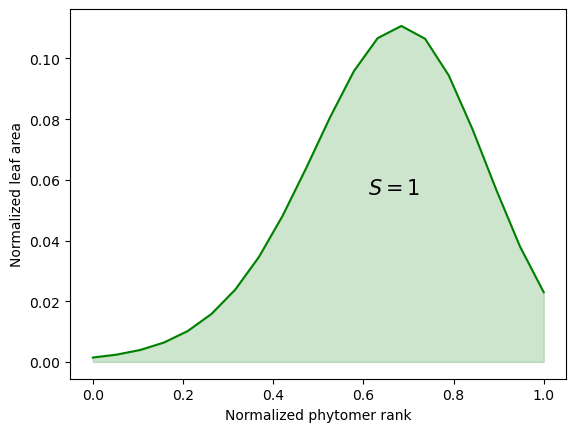

In [25]:
rmax = 0.7
skew = 0.0005
Smax = 1

leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

plt.plot(np.linspace(0,1,20), leaf_areas, color="g")
plt.plot()
plt.fill_between(np.linspace(0,1,20), [0]*len(leaf_areas), leaf_areas, color="g", alpha=0.2)
# plt.ylim(0,max(leaf_areas)+0.005)
plt.xlabel("Normalized phytomer rank")
plt.ylabel("Normalized leaf area")
plt.text(rmax-0.09, max(leaf_areas)/2, '$S = 1$', fontsize = 15)
plt.show()

- Scale the leaf areas according to the given maximal plant leaf area $S_{max}$, to obtain 
$s_{i, potential}$ for each leaf $i$.

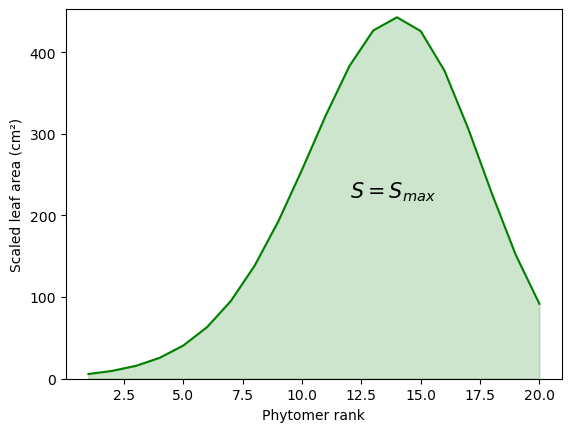

In [26]:
Smax = 4000
scaled_leaf_areas = bell_shaped_dist(Smax, nb_phy, rmax, skew)

plt.plot(range(1,len(scaled_leaf_areas)+1), scaled_leaf_areas, color="g")
plt.fill_between(range(1,len(scaled_leaf_areas)+1), [0]*len(scaled_leaf_areas), scaled_leaf_areas, color="g", alpha=0.2)
plt.ylim(0,max(scaled_leaf_areas)+10)
plt.xlabel("Phytomer rank")
plt.ylabel("Scaled leaf area (cm²)")
plt.text(rmax*nb_phy-2, max(scaled_leaf_areas)/2, '$S = S_{max}$', fontsize = 15)
plt.show()

At each time step, distribute the increment of given plant leaf area $\frac{dS_{constraint}(t)}{dt}$ among $g$ growing leaves.

Let’s consider $F(\alpha_1 x_1,…,\alpha_g x_g) = \sum_{i=1}^{g} \alpha_i x_i$, where $\sum_{i=1}^{g} \alpha_i = 1$ and $x_i = ds_i$ or $dh_i$

 


$H_{1.0}$ : Equal distribution of the gain among all growing vegetative organs 

For a growing leaf $i$ among $g$ growing leaves in a plant, given a plant leaf area increment $dS(t)$ for the plant at time $t$, the leaf area increment $ds_i(t)$ is:   
$ds_i(t)=\frac{dS(t)}{g}$ with $\alpha_1=\dots=\alpha_g=\frac{1}{g}$
 

In [27]:
def equal_distribution(ds, g):
    return [ds/g for i in range(g)]

$H_{1.1}$: Demand of leaf area proportionnal to final area

For a growing leaf $i$ of potential leaf area $S_{i}^{max}$ among $g$ growing leaves in a plant, given a plant leaf area increment $dS(t)$ for the plant at time $t$, the leaf area increment $ds_i(t)$ is:   
$ds_i(t)=\alpha_i \times  dS(t) $ such that $\alpha_{i} = \frac{S_{i}^{max}}{\sum^{g}_{j=1} S_{j}^{max}} $ and $\sum^{g}_{i=1} \alpha_{i} = 1$

In [28]:
def demand_related_distribution(ds, potential_areas_growing_leaves):
    sum_areas_growing_leaves = sum(potential_areas_growing_leaves)
    return [ds*pi/sum_areas_growing_leaves for pi in potential_areas_growing_leaves]

ds = 10
potential_areas_growing_leaves = [5,8,6]
print(demand_related_distribution(ds, potential_areas_growing_leaves))

[2.6315789473684212, 4.2105263157894735, 3.1578947368421053]


$H_{1.2}$: Partition of unity with Bernstein polynomials of degree $g-1$: 

$\alpha_{i, g−1}(x)= \frac{(g−1)!}{i!(g−1−i)!} x^i (1−x)^{g−1−i}$ such that $\sum^{g−1}_{i=0} \alpha_{i, g−1} (x) = 1, \forall x \in [0,1]$

in progress

In [29]:
def bernstein_polynomials(n, x): # n = g-1
    """
    Compute Bernstein polynomials of degree n at point x (in [0,1]).
    Returns a list of coefficients for partition of unity.
    """
    bernstein = []
    for i in range(n + 1):
        bin_coeff = math.comb(n, i)  # Binomial coefficient
        bernstein.append(bin_coeff * (x**i) * ((1 - x)**(n - i)))
    return bernstein

In [30]:
def partition_of_unity(x_fixed):
    """
    
    """
    # print("Bernstein Polynomials:")
    g_range = [2,3,4]
    x_range = np.arange(0,1.1,0.1)
    
    fig, axes = plt.subplots(1,len(g_range), figsize=(12, 4))
    
    for g in g_range:
        # print(f"For {g} growing organs:")
        n = g - 1
        values = {i: [] for i in range(1, g + 1)}
        
        for x in x_range:
            bernstein = bernstein_polynomials(n, x)
            for j,b in enumerate(bernstein):
                values[j+1].append(round(b,5))
            # print(f"    - at point {round(x,1)}", bernstein)
    
        for k,v in values.items():
            axes[g-2].plot(x_range, v, color='green')
            axes[g-2].text(x_fixed, v[int(x_fixed*10)], f"{k}")
        axes[g-2].set_title(f"For {g} growing organs")
        axes[g-2].plot([x_fixed]*2,[0,1], linestyle='--', color='gray')
    
    plt.suptitle("Partition of unity with Bernstein polynomials")
    plt.subplots_adjust(wspace=0.2)
    plt.show()

interact(partition_of_unity, x_fixed=FloatSlider(min=0.0,max=1.0,step=0.1,value=0.3))

interactive(children=(FloatSlider(value=0.3, description='x_fixed', max=1.0), Output()), _dom_classes=('widget…

<function __main__.partition_of_unity(x_fixed)>

## From leaf area increment to leaf length increment

Leaf shape

In [31]:
wl = 0.12

In [32]:
def leaf_elongation(l, dl):
    sp, rp = sr_dornbush()
    ss = int(l*100)
    dss = int(dl*100)
    plt.plot(sp, rp, color="g")
    plt.plot(sp, -rp, color="g")
    plt.plot(sp,[0]*len(rp), color="g", linestyle="--")
    plt.fill_between(sp[-ss:], -rp[-ss:], rp[-ss:], color="g", alpha=0.2)
    plt.fill_between(sp[-(ss+dss):], -rp[-(ss+dss):], rp[-(ss+dss):], color="g", alpha=0.2)
    # plt.text(max(0,1-(l+dl))+0.03, 0.1, f"dl = {round(min(dl,1.0-l),5)}")
    plt.xlabel("Normalized leaf length")
    plt.ylabel("Normalized leaf width")
    plt.show()

interact(leaf_elongation, l=FloatSlider(min=0.001,max=1.001,step=0.05,value=0.3), dl=FloatSlider(min=0.0,max=1.0,step=0.05,value=0.1))

interactive(children=(FloatSlider(value=0.3, description='l', max=1.001, min=0.001, step=0.05), FloatSlider(va…

<function __main__.leaf_elongation(l, dl)>

l = f(S) curve fitting

With Prevot leaf shape

In [33]:
from scipy.integrate import cumulative_simpson

l,p = sr_prevot()
p = p[::-1]
S = cumulative_simpson(x=l, y=p, initial=0)
S_norm = S / S[-1]

plt.plot(l,p)
plt.plot(l,S_norm)
plt.show()

NameError: name 'sr_prevot' is not defined

In [ ]:
from scipy.interpolate import splrep, splev

t,c,k = splrep(x=S_norm, y=l, k=3, task=0)

y = splev(x=S_norm, tck=(t,c,k))

plt.plot(S_norm, y)
plt.plot(l, S_norm)
plt.show()

In [ ]:
S_t = 0.3
print(f"For a surface of {S_t}, we get a leaf length of {round(float(splev(x=S_t, tck=(t,c,k))),4)}")

With Dornbush leaf shape

In [ ]:
from scipy.interpolate import splrep, splev

# 100 pts
l, p = sr_dornbush(nb_segment=100)
p = p[::-1]
S = cumulative_simpson(x=l, y=p, initial=0)
S_norm = S / S[-1]

t,c,k = splrep(x=S_norm, y=l, k=3, task=0)

y = splev(x=S_norm, tck=(t,c,k))

S_t = 0.0001
print(f"For a surface of {S_t}, we get a leaf length of {round(float(splev(x=S_t, tck=(t,c,k))),10)}")

plt.plot(l,p,'g', alpha=0.5)
plt.plot(l,S_norm,'r', alpha=0.5)
plt.plot(S_norm, y,'orange', alpha=0.5)

# 1000 pts

l_1000, p_1000 = sr_dornbush(nb_segment=1000)
p_1000 = p_1000[::-1]
S_1000 = cumulative_simpson(x=l_1000, y=p_1000, initial=0)
S_norm_1000 = S_1000 / S_1000[-1]

t_1000,c_1000,k_1000 = splrep(x=S_norm_1000, y=l_1000, k=3, task=0)

y_1000 = splev(x=S_norm_1000, tck=(t_1000,c_1000,k_1000))

# print(f"For a surface of {S_t}, we get a leaf length of {round(float(splev(x=S_t, tck=(t_1000,c_1000,k_1000))),10)}")

plt.plot(l_1000,p_1000,'g')
plt.plot(l_1000,S_norm_1000,'r')
plt.plot(S_norm_1000, y_1000,'orange')

y_1000_to_100 = np.array([v for i,v in enumerate(y_1000) if i%10==0])

plt.plot(S_norm, y_1000_to_100-y, 'b')

# print(y_1000_to_100-y)

plt.show()

Discretizing leaf area to get dS-to-dl correspondance easily

In [ ]:
L = 1
wl = 1
dl = 0.05*L 
l_values = np.arange(0.0, L+dl, dl) 

ds_list = [0.0]
for l in l_values[1:]:
    ds_list.append(d_leaf_area(l,dl,L,wl))
# print(ds_list)
# print(np.sum(ds_list))

fig, ax1 = plt.subplots()

ax1.bar(l_values, ds_list, width=dl, color="g", alpha=0.4)
ax1.set_xlabel("Normalized leaf length l")
ax1.set_ylabel("Discretized dS/dl")
         
ax2 = ax1.twinx()  

ax2.plot(l_values, np.cumsum(ds_list), color="g")
ax2.set_ylabel("Cumulated sum of leaf area along midrib : S = w(l)")
ax2.set_ylim(0,np.sum(ds_list))

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [ ]:
from scipy.interpolate import BSpline, make_interp_spline, UnivariateSpline

ds_cumsum = np.cumsum(ds_list)

# # Create a B-spline with degree k=2 (quadratic spline)
# k = 3  # Degree of the spline
# bspline = make_interp_spline(ds_cumsum, l_values, k=k)

# # # Evaluate spline and approximate expressions
# # l_new = bspline(ds_cumsum)

# # Extract knots, coefficients, and degree
# knots = bspline.t  # Knot vector
# coefficients = bspline.c  # Spline coefficients
# degree = bspline.k  # Degree of the spline

# # Define symbolic variable
# x = symbols('x')

# # Generate the B-spline piecewise expression
# piecewise_expr = []
# for i in range(len(coefficients) - degree - 1):
#     # Get the polynomial coefficients for the current interval
#     basis_poly = BSpline.basis_element(knots[i:i+degree+2])
#     piece_expr = sum(c * (x - knots[i])**j for j, c in enumerate(basis_poly.c))
#     condition = (x >= knots[i]) & (x < knots[i + 1])
#     piecewise_expr.append((piece_expr, condition))

# # Combine into a symbolic piecewise expression
# b_spline_expr = Piecewise(*piecewise_expr)
# print("B-Spline Expression:", b_spline_expr)



cs_ds = CubicSpline(ds_cumsum, l_values, bc_type="natural")
l_interp = cs_ds(ds_cumsum)  

# Define symbolic variable
x = symbols('x')
piecewise_expr = []

for i in range(len(ds_cumsum) - 1):
    # Coefficients for the interval [x_points[i], x_points[i+1]]
    c0, c1, c2, c3 = cs_ds.c[:, i]
    xi = ds_cumsum[i]
    poly = c0 + c1 * (x - xi) + c2 * (x - xi)**2 + c3 * (x - xi)**3
    piecewise_expr.append((poly, (x >= xi) & (x < ds_cumsum[i + 1])))

# Combine into a single Piecewise expression
spline_expr = Piecewise(*piecewise_expr)
# print("Spline expression:", spline_expr)

# plt.plot(ds_cumsum, [spline_expr.subs(x, ds) for ds in ds_cumsum], color="red")

# plt.scatter(ds_cumsum, l_values, color="g")
# plt.plot(ds_cumsum, basis_poly, color="black")
plt.plot(ds_cumsum, l_interp, color="black")
# plt.plot(ds_cumsum, poly, color="black")
plt.xlabel("Cumulated sum of leaf area along midrib : S = w(l)")
plt.ylabel("Normalized leaf length l")
plt.show()

In [ ]:
corres_dl_dS = {}
for i,dl in enumerate(l_values):
    corres_dl_dS[dl] = np.cumsum(ds_list)[i]
# print(corres_dl_dS)

In [ ]:
l = 0
dS_input = 0.02

def search_new_dl(d, l, dS_input, L=1):
    found_start = False  
    first = True
    key_prev = None
    value_prev = None
    for key, value in d.items():
        if key >= l:
            found_start = True  
            if first:
                S_start = value
                key_prev, value_prev = key, value
                first = False
        if found_start:
            # print(key, value-S_start)
            if value-S_start >= dS_input:  
                return key_prev, value_prev 
            else:
                key_prev, value_prev = key, value
    return L, value  # if no match is found --> finished

result = search_new_dl(corres_dl_dS, l, dS_input)
print("New l = ", round(result[0],4))

Whole process for one leaf

In [ ]:
l = 0
l_list = [l]
dS_new_list = [0]
for dS_input in dy_dense:
    l, dS_new = search_new_dl(corres_dl_dS, l, dS_input, L=3000)
    l_list.append(l)
    dS_new_list.append(dS_new)

# plt.plot(l_list, dS_new_list, color="g")
# plt.show()

In [ ]:
plt.plot(x_dense, dS_new_list[:-1], color="g")
plt.plot(x_dense, y_dense, color="orange")
plt.show()

For several leaves

In [ ]:
# dev

# for loop
    # distribute among growing leaves
    # for each growing leaf
        # translate dS in dl (check potential size)

# compare plant profiles of potential and constraint

- Analytical resolution of dl (in progress)

In [ ]:
L = 1
dS_range = np.arange(0.01,0.1,0.01)
x = np.arange(0.05,1.05*L,0.05)

fig, ax = plt.subplots(2,1)

ax[0].plot([0]+x, [3.03*l**2*wl - 1.53*l**3*wl/L for l in [0]+x], color="g")
ax[0].set_ylabel("S = w(l)")
for dS in dS_range:
    ax[1].plot(x, [dS/(3.03*l**2*wl - 1.53*l**3*wl/L) for l in x])
ax[1].set_ylabel("dl ?")
ax[1].set_xlabel("Leaf length l, from tip to base")
plt.show()

for l in x:
    print("l :", round(l,3), "dl :", round(dS/(3.03*l**2*wl - 1.53*l**3*wl/L),3))